In [1]:
import fastf1
import fastf1.api
import fastf1.plotting

import pandas as pd
import numpy as np
import os  
from datetime import timedelta
import csv
import seaborn as sns
from fastf1.ergast import Ergast

ergast = Ergast()

year = 2025
race_number = 11
race_session = 'R'
Lap_Number = 42

#year = int(input("Year ? "))
#race_number = int(input("Race Number ? (1-24) "))
#race_session = input('Session ?  (S, R) ')

session= fastf1.get_session(year, race_number, race_session)
session.load()

pit = ergast.get_pit_stops(season = year, round = race_number )
teams = fastf1.plotting.list_team_names(session)
event_name = session.event.EventName

/home/kurios/Documents/f1_analysis/f1_analysis_env/lib/python3.10/site-packages/fastf1/api.py:32: UserWarning: `fastf1.api` will be considered private in future releases and potentially be removed or changed!
  warnings.warn("`fastf1.api` will be considered private in future releases and "
req         WARNING 	DEFAULT CACHE ENABLED! (29.14 GB) /home/kurios/.cache/fastf1
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for

In [12]:
def get_sorted_first_position_times(session):
    all_first_position_times = []

    for driver in session.drivers:
        driver_lap = session.laps.pick_drivers(driver)
        first_position_times_for_driver = driver_lap.Time[driver_lap.Position == 1]
        all_first_position_times.extend(first_position_times_for_driver.tolist())

    all_first_position_times.sort()

    return all_first_position_times
sorted_times = get_sorted_first_position_times(session)

EACH DRIVER

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Direction
69,01:09:19.945,19.1,73,988.6,False,24.0,16,2.6,NNE
60,01:00:19.880,18.4,80,988.6,False,24.5,66,1.5,ENE
56,00:56:19.847,18.3,80,988.7,False,24.1,0,0.9,N


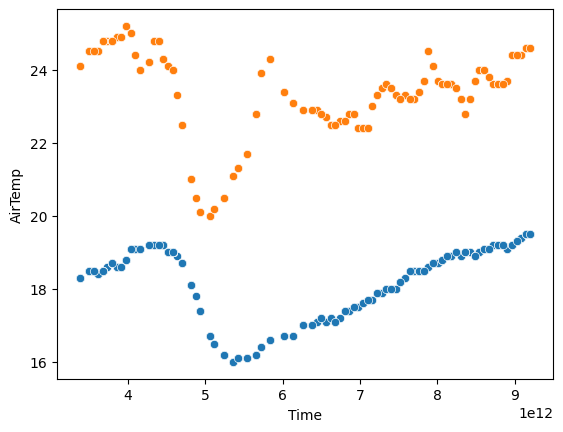

In [13]:
weather_driver_lap = session.laps.get_weather_data()
def get_wind_direction_cat(WindDirection):
    normalized_direction = WindDirection % 360
    if normalized_direction < 0:
        normalized_direction += 360
    match normalized_direction:
        case _ if (normalized_direction >= 348.75 or normalized_direction < 11.25):
            return 'N'
        case _ if (normalized_direction >= 11.25 and normalized_direction < 33.75):
            return 'NNE'
        case _ if (normalized_direction >= 33.75 and normalized_direction < 56.25):
            return 'NE'
        case _ if (normalized_direction >= 56.25 and normalized_direction < 78.75):
            return 'ENE'
        case _ if (normalized_direction >= 78.75 and normalized_direction < 101.25):
            return 'E'
        case _ if (normalized_direction >= 101.25 and normalized_direction < 123.75):
            return 'ESE'
        case _ if (normalized_direction >= 123.75 and normalized_direction < 146.25):
            return 'SE'
        case _ if (normalized_direction >= 146.25 and normalized_direction < 168.75):
            return 'SSE'
        case _ if (normalized_direction >= 168.75 and normalized_direction < 191.25):
            return 'S'
        case _ if (normalized_direction >= 191.25 and normalized_direction < 213.75):
            return 'SSW'
        case _ if (normalized_direction >= 213.75 and normalized_direction < 236.25):
            return 'SW'
        case _ if (normalized_direction >= 236.25 and normalized_direction < 258.75):
            return 'WSW'
        case _ if (normalized_direction >= 258.75 and normalized_direction < 281.25):
            return 'W'
        case _ if (normalized_direction >= 281.25 and normalized_direction < 303.75):
            return 'WNW'
        case _ if (normalized_direction >= 303.75 and normalized_direction < 326.25):
            return 'NW'
        case _ if (normalized_direction >= 326.25 and normalized_direction < 348.75):
            return 'NNW'
        case _:
            return 'Invalid'

weather_driver_lap['Direction'] = weather_driver_lap['WindDirection'].apply(get_wind_direction_cat)
i = np.argmin(np.abs(weather_driver_lap.Time - timedelta(hours=1)))
i_10min = np.argmin(np.abs(weather_driver_lap.Time - timedelta(hours=1, minutes=10)))
i_10plus = np.argmin(np.abs(weather_driver_lap.Time - timedelta(minutes=50)))
weather_evolution = [weather_driver_lap.iloc[i_10min], weather_driver_lap.iloc[i], weather_driver_lap.iloc[i_10plus]]
weather_evolution_df = pd.DataFrame(weather_evolution)
weather_evolution_df.Time = weather_evolution_df.Time.astype('str').str[7:-3]
weather_evolution_df.Humidity = weather_evolution_df.Humidity.astype('int')
sns.scatterplot(data = weather_driver_lap, x='Time', y='AirTemp')
sns.scatterplot(data = weather_driver_lap, x='Time', y='TrackTemp')
weather_evolution_df

CURENT STATUS

In [ ]:
def highlight_compound(s):
    colors = []
    for compound_value in s:
        if compound_value == 'SOFT':
            colors.append('color: red')
        elif compound_value == 'MEDIUM':
            colors.append('color: yellow')
        elif compound_value == 'HARD':
            colors.append('color: white')
        elif compound_value == 'INTERMEDIATE':
            colors.append('color: green')
        elif compound_value == 'WET':
            colors.append('color: blue')
        else:
            colors.append('color: grey')
    return colors

def highlight_driver(s):
    drivers = []
    for driver_name in s:
        if driver_name == 'VER' or driver_name == 'TSU':
            drivers.append('color: #0600ef')
        elif driver_name == 'GAS' or driver_name == 'DOO' or driver_name == 'COL':
            drivers.append('color: #ff87bc')
        elif driver_name == 'RUS' or driver_name == 'ANT':
            drivers.append('color: #27f4d2')
        elif driver_name == 'ALO' or driver_name == 'STR':
            drivers.append('color: #00665f')
        elif driver_name == 'LEC' or driver_name == 'HAM':
            drivers.append('color: #e80020')
        elif driver_name == 'ALB' or driver_name == 'SAI':
            drivers.append('color: #00a0dd')
        elif driver_name == 'HUL' or driver_name == 'BOR':
            drivers.append('color: #00e700')
        elif driver_name == 'HAD' or driver_name == 'LAW':
            drivers.append('color: #fcd700')
        elif driver_name == 'BEA' or driver_name == 'OCO':
            drivers.append('color: #b6babd')
        elif driver_name == 'NOR' or driver_name == 'PIA':
            drivers.append('color: #ff8000')
        else:
            drivers.append('color: grey')
    return drivers
drivers_data = []
driver_data_cols = [
    'Position', '№_Driver', 'Driver_Color', 'Driver', 'Time',
    'Sector1', 'I1', 'Sector2', 'I2', 'Sector3',
    'FL', 'LapTime', 'ST', 'Lap', 'Compound', 'PitStop'
]

leader_driver_number = None
leader_lap_time_reference = None
leader_snapshot_lap_data = None

laps_at_snapshot = session.laps[session.laps['LapNumber'] == Lap_Number]

if not laps_at_snapshot.empty:
    leader_snapshot_lap_data = laps_at_snapshot.sort_values(by='Position').iloc[0]
    leader_driver_number = leader_snapshot_lap_data['DriverNumber']
    leader_lap_time_reference = leader_snapshot_lap_data['Time']
    try:
        leader_color = fastf1.plotting.get_driver_color(leader_snapshot_lap_data.Driver, session)
        leader_data = [
            leader_snapshot_lap_data.Position, leader_driver_number, leader_color, leader_snapshot_lap_data.Driver,
            leader_snapshot_lap_data.Time, leader_snapshot_lap_data.Sector1Time, leader_snapshot_lap_data.SpeedI1,
            leader_snapshot_lap_data.Sector2Time, leader_snapshot_lap_data.SpeedI2, leader_snapshot_lap_data.Sector3Time,
            leader_snapshot_lap_data.SpeedFL, leader_snapshot_lap_data.LapTime, leader_snapshot_lap_data.SpeedST,
            leader_snapshot_lap_data.LapNumber, leader_snapshot_lap_data.Compound, (leader_snapshot_lap_data.Stint - 1)
        ]
        drivers_data.append(pd.Series(leader_data, index=driver_data_cols))
    except Exception as e:
        print(f"Could not process leader's data for Lap {Lap_Number}. Error: {e}")
        exit()
else:
    print(f"No data available for Lap {Lap_Number} to determine the leader. Cannot proceed.")
    exit()


for driver_num in session.drivers:
    if driver_num == leader_driver_number:
        continue

    driver_laps = session.laps.pick_drivers(driver_num)
    potential_laps_after_leader = driver_laps[(driver_laps['Time'] >= leader_lap_time_reference)].copy()
    selected_lap = None
    if not potential_laps_after_leader.empty:
        selected_lap = potential_laps_after_leader.sort_values(by='LapNumber').iloc[0]
    else:
        fallback_lap = driver_laps[driver_laps['LapNumber'] == Lap_Number]
        if not fallback_lap.empty:
            selected_lap = fallback_lap.iloc[0]
        else:
            if not driver_laps.empty:
                selected_lap = driver_laps.iloc[-1]
            else:
                continue

    if selected_lap is not None and not selected_lap.empty:
        try:
            driver_color = fastf1.plotting.get_driver_color(selected_lap.Driver, session)
            driver_data = [
                selected_lap.Position, driver_num, driver_color, selected_lap.Driver,
                selected_lap.Time, selected_lap.Sector1Time, selected_lap.SpeedI1,
                selected_lap.Sector2Time, selected_lap.SpeedI2, selected_lap.Sector3Time,
                selected_lap.SpeedFL, selected_lap.LapTime, selected_lap.SpeedST,
                selected_lap.LapNumber, selected_lap.Compound, (selected_lap.Stint - 1)
            ]
            drivers_data.append(pd.Series(driver_data, index=driver_data_cols))
        except Exception as e:
            continue

drivers_data_df = pd.DataFrame(drivers_data)

if drivers_data_df.empty:
    print(f"No driver data collected for this scenario. Check session data and logic.")
else:
    drivers_data_df = drivers_data_df.fillna(0).infer_objects(copy=False)
    drivers_data_df = drivers_data_df.sort_values('Position').reset_index(drop=True)

    drivers_data_df['Time_td'] = drivers_data_df['Time']
    drivers_data_df['Gap_ahead_Driver'] = drivers_data_df['Time_td'].diff()
    drivers_data_df['Gap_to_Leader'] = drivers_data_df['Time_td'] - drivers_data_df['Time_td'].iloc[0]
    for col in ['Sector1', 'Sector2', 'Sector3', 'LapTime']:
        if pd.api.types.is_timedelta64_dtype(drivers_data_df[col]):
            drivers_data_df[col] = drivers_data_df[col].astype(str).str[13:-3]
        elif isinstance(drivers_data_df[col].iloc[0], pd.Timedelta):
            drivers_data_df[col] = drivers_data_df[col].astype(str).str[13:-3]
        else:
            drivers_data_df[col] = drivers_data_df[col].astype(str)

    drivers_data_df = drivers_data_df.drop(columns=['Time_td'])
    drivers_data_df = drivers_data_df.drop(columns=['Driver_Color'])
    drivers_data_df = drivers_data_df[drivers_data_df['Position']>0]

    styled_df = drivers_data_df.style
    styled_df = styled_df.apply(highlight_driver, subset=['Driver'])
    styled_df = styled_df.apply(highlight_compound, subset=['Compound'])

    formatters = {
    
    'Position': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
    'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'I1': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'I2': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'FL': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'No Data',
    'ST': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Lap': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'PitStop': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Gap_ahead_Driver': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
    'Gap_to_Leader': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
    }

    final_formatters = {k: v for k, v in formatters.items() if k in drivers_data_df.columns}
    styled_df = styled_df.format(final_formatters)
styled_df
    

,Position,№_Driver,Driver,Time,Sector1,I1,Sector2,I2,Sector3,FL,LapTime,ST,Lap,Compound,PitStop,Gap_ahead_Driver,Gap_to_Leader
3,1,4,NOR,02:02:15.753,17.655,299,31.137,231,21.016,275,1:09.808,295,42,HARD,1,00:49:38.341,00:49:38.341
4,2,81,PIA,02:02:18.813,17.618,299,31.165,235,21.017,275,1:09.800,298,42,HARD,1,00:00:03.060,00:49:41.401
5,3,16,LEC,02:02:32.881,17.555,298,31.170,230,21.054,274,1:09.779,296,42,HARD,1,00:00:14.068,00:49:55.469
6,4,44,HAM,02:02:37.736,17.577,296,31.210,227,21.300,274,1:10.087,296,42,HARD,1,00:00:04.855,00:50:00.324
7,5,63,RUS,02:02:57.439,17.733,296,31.705,227,21.265,272,1:10.703,296,42,MEDIUM,1,00:00:19.703,00:50:20.027
8,6,5,BOR,02:03:01.665,17.748,293,31.481,229,21.283,271,1:10.512,291,42,MEDIUM,1,00:00:04.226,00:50:24.253
9,7,31,OCO,02:03:08.393,17.696,295,31.536,224,21.597,279,1:10.829,292,42,HARD,1,00:00:06.728,00:50:30.981
10,8,27,HUL,02:03:09.915,17.813,292,31.705,225,24.961,0,1:14.479,291,42,MEDIUM,1,00:00:01.522,00:50:32.503
11,9,30,LAW,02:03:14.344,17.717,289,31.164,230,21.115,273,1:09.996,290,42,HARD,1,00:00:04.429,00:50:36.932
12,10,14,ALO,02:03:15.239,17.280,302,31.342,227,21.342,279,1:09.964,305,42,HARD,1,00:00:00.895,00:50:37.827


In [5]:
drivers_data = []
driver_data_cols = ['Time', 'Position', 'Driver_Number', 'Driver_Color', 'Driver_Name', 'Status']
for driver in session.drivers:
    driver_lap = session.laps.pick_drivers(driver)
    try:
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_lap.Time.iloc[Lap_Number], driver_lap.Position.iloc[Lap_Number], driver, driver_color, driver_lap.Driver.iloc[Lap_Number], driver_lap.Time.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    drivers_data.append(driver_data_series)
drivers_data_df = pd.DataFrame(drivers_data)
drivers_data_df = drivers_data_df.fillna(0)
drivers_data_df.Time = drivers_data_df.Time.astype('str').str[6:-3]
drivers_data_df.Position = drivers_data_df.Position.astype('int')
drivers_data_df.Status = drivers_data_df.Status.astype('str').str[6:-3]
drivers_data_df

,Time,Position,Driver_Number,Driver_Color,Driver_Name,Status
0,02:31:54.314,1,4,#ff8000,NOR,02:31:54.314
1,02:31:59.435,2,81,#ff8000,PIA,02:31:59.435
2,02:32:28.047,3,27,#00e700,HUL,02:32:28.047
3,02:32:33.162,4,44,#e80020,HAM,02:32:33.162
4,02:32:50.337,5,1,#0600ef,VER,02:32:50.337
5,02:32:52.983,7,10,#ff87bc,GAS,02:32:52.983
6,02:32:52.343,6,18,#00665f,STR,02:32:52.343
7,02:32:58.614,9,23,#00a0dd,ALB,02:32:58.614
8,02:32:58.075,8,14,#00665f,ALO,02:32:58.075
9,02:33:03.752,10,63,#27f4d2,RUS,02:33:03.752


PER DRIVER

In [17]:
driver_data_last_laps = []

def highlight(s, min_max):
    if min_max == 'min':
        is_min_max = s == s.min()
    if min_max == 'max':
        is_min_max = s == s.min()

    return ['color: green' if v else 'color: orange' for v in is_min_max]


for Lap_Number in range(41,51):
    driver_data_cols = ['Time', 'LapNumber', 'Sector1_Time', 'SpeedI1', 'Sector2_Time', 'SpeedI2', 'Sector3_Time', 'SpeedFL', 'LapTime', 'SpeedST']
    driver = 4
    driver_lap = session.laps.pick_drivers(driver)
    try:
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_lap.Time.iloc[Lap_Number], driver_lap.LapNumber.iloc[Lap_Number], driver_lap.Sector1Time.iloc[Lap_Number], driver_lap.SpeedI1.iloc[Lap_Number], driver_lap.Sector2Time.iloc[Lap_Number], driver_lap.SpeedI2.iloc[Lap_Number], driver_lap.Sector3Time.iloc[Lap_Number], driver_lap.SpeedFL.iloc[Lap_Number], driver_lap.LapTime.iloc[Lap_Number], driver_lap.SpeedST.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_last_laps.append(driver_data_series)
driver_data_last_laps_df = pd.DataFrame(driver_data_last_laps)
styled_df = driver_data_last_laps_df.style

styled_df = styled_df.apply(highlight, subset=['Sector1_Time'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['SpeedI1'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector2_Time'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['SpeedI2'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector3_Time'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['SpeedFL'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['LapTime'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['SpeedST'], min_max='max')

formatters = {
    'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
    'LapNumber': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector1_Time': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'SpeedI1': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector2_Time': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'SpeedI2': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'Sector3_Time': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
    'SpeedFL': lambda x: int(x) if pd.notnull(x) else 'No Data',
    'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'No Data',
    'SpeedST': lambda x: int(x) if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_last_laps_df.columns}
styled_df = styled_df.format(final_formatters)

styled_df

,Time,LapNumber,Sector1_Time,SpeedI1,Sector2_Time,SpeedI2,Sector3_Time,SpeedFL,LapTime,SpeedST
0,02:17:36.487,42,31.697,No Data,40.554,247,26.527,246,1:38.778,306
1,02:19:15.492,43,31.622,No Data,40.853,244,26.530,245,1:39.005,308
2,02:20:54.395,44,31.454,276,41.257,245,26.192,No Data,1:38.903,244
3,02:22:52.343,45,52.626,295,39.764,256,25.558,251,1:57.948,306
4,02:24:24.120,46,29.904,296,37.422,263,24.451,255,1:31.777,310
5,02:25:54.155,47,28.822,291,36.828,263,24.385,255,1:30.035,308
6,02:27:23.889,48,28.748,297,36.674,264,24.312,254,1:29.734,311
7,02:28:54.124,49,28.701,299,37.042,260,24.492,254,1:30.235,313
8,02:30:24.045,50,28.791,297,36.732,264,24.398,254,1:29.921,310
9,02:31:54.314,51,28.710,298,37.048,263,24.511,253,1:30.269,312


In [ ]:
messages = fastf1.api.race_control_messages(session.api_path)
messages_df = pd.DataFrame.from_dict(messages)
messages_df= messages_df.drop(columns=['Sector', 'RacingNumber'])

req            INFO 	Using cached data for race_control_messages


,Time,Category,Message,Status,Flag,Scope,Sector,RacingNumber,Lap
0,2025-06-29 12:20:01,Flag,GREEN LIGHT - PIT EXIT OPEN,None,GREEN,Track,NaN,None,1
1,2025-06-29 12:20:26,Flag,YELLOW IN TRACK SECTOR 3,None,YELLOW,Sector,3.0,None,1
2,2025-06-29 12:20:27,Other,DRS DISABLED IN ZONE 1,None,None,None,NaN,None,1
3,2025-06-29 12:20:36,Flag,CLEAR IN TRACK SECTOR 3,None,CLEAR,Sector,3.0,None,1
4,2025-06-29 12:20:36,Other,DRS ENABLED IN ZONE 1,None,None,None,NaN,None,1
...,...,...,...,...,...,...,...,...,...
112,2025-06-29 14:46:17,Flag,YELLOW IN TRACK SECTOR 9,None,YELLOW,Sector,9.0,None,70
113,2025-06-29 14:46:18,Other,DRS DISABLED IN ZONE 2,None,None,None,NaN,None,70
114,2025-06-29 14:47:32,Flag,CLEAR IN TRACK SECTOR 9,None,CLEAR,Sector,9.0,None,70
115,2025-06-29 14:47:32,Other,DRS ENABLED IN ZONE 2,None,None,None,NaN,None,70


Sector1

In [ ]:
def highlight_compound(s):
    colors = []
    for compound_value in s:
        if compound_value == 'SOFT':
            colors.append('color: red')
        elif compound_value == 'MEDIUM':
            colors.append('color: yellow')
        elif compound_value == 'HARD':
            colors.append('color: white')
        elif compound_value == 'INTERMEDIATE':
            colors.append('color: green')
        elif compound_value == 'WET':
            colors.append('color: blue')
        else:
            colors.append('color: grey')
    return colors

def highlight_driver(s):
    drivers = []
    for driver_name in s:
        if driver_name == 'VER' or driver_name == 'TSU':
            drivers.append('color: #0600ef')
        elif driver_name == 'GAS' or driver_name == 'DOO' or driver_name == 'COL':
            drivers.append('color: #ff87bc')
        elif driver_name == 'RUS' or driver_name == 'ANT':
            drivers.append('color: #27f4d2')
        elif driver_name == 'ALO' or driver_name == 'STR':
            drivers.append('color: #00665f')
        elif driver_name == 'LEC' or driver_name == 'HAM':
            drivers.append('color: #e80020')
        elif driver_name == 'ALB' or driver_name == 'SAI':
            drivers.append('color: #00a0dd')
        elif driver_name == 'HUL' or driver_name == 'BOR':
            drivers.append('color: #00e700')
        elif driver_name == 'HAD' or driver_name == 'LAW':
            drivers.append('color: #fcd700')
        elif driver_name == 'BEA' or driver_name == 'OCO':
            drivers.append('color: #b6babd')
        elif driver_name == 'NOR' or driver_name == 'PIA':
            drivers.append('color: #ff8000')
        else:
            drivers.append('color: grey')
    return drivers

driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Color', 'Driver', 'Sector1', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_color, driver_lap.Driver.iloc[Lap_Number], np.min(driver_lap.Sector1Time), driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
styled_df = driver_data_best_laps_df.style
styled_df = styled_df.apply(highlight_compound, subset=['Compound'])
styled_df = styled_df.apply(highlight_driver, subset=['Driver'])

formatters = {
    'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_best_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

['Red Bull Racing', 'Alpine', 'Mercedes', 'Aston Martin', 'Ferrari', 'Williams', 'Kick Sauber', 'Racing Bulls', 'Haas F1 Team', 'McLaren']
#0600ef
#ff87bc
#27f4d2
#00665f
#e80020
#00a0dd
#00e700
#fcd700
#b6babd
#ff8000


,Color,Driver,Sector1,Compound
0,#ff8000,NOR,17.393,HARD
1,#ff8000,PIA,17.162,HARD
2,#e80020,LEC,17.275,HARD
3,#e80020,HAM,17.367,HARD
4,#27f4d2,RUS,17.210,MEDIUM
5,#fcd700,LAW,17.229,HARD
6,#00665f,ALO,17.254,HARD
7,#00e700,BOR,17.326,MEDIUM
8,#00e700,HUL,17.252,MEDIUM
9,#b6babd,OCO,17.285,HARD


In [21]:
driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Color', 'Driver', 'Sector2', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_color, driver_lap.Driver.iloc[Lap_Number], np.min(driver_lap.Sector2Time), driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
styled_df = driver_data_best_laps_df.style
styled_df = styled_df.apply(highlight_compound, subset=['Compound'])

formatters = {
    'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_best_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

,Color,Driver,Sector2,Compound
0,#ff8000,NOR,30.853,HARD
1,#ff8000,PIA,30.864,HARD
2,#e80020,LEC,30.743,HARD
3,#e80020,HAM,30.773,HARD
4,#27f4d2,RUS,30.822,MEDIUM
5,#fcd700,LAW,31.143,HARD
6,#00665f,ALO,31.203,HARD
7,#00e700,BOR,31.070,MEDIUM
8,#00e700,HUL,31.144,MEDIUM
9,#b6babd,OCO,30.931,HARD


In [25]:
driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Color', 'Driver', 'Sector3', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_color, driver_lap.Driver.iloc[Lap_Number], np.min(driver_lap.Sector3Time), driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
driver_data_best_laps_df = driver_data_best_laps_df.sort_values('Sector3')
styled_df = driver_data_best_laps_df.style
styled_df = styled_df.apply(highlight_compound, subset=['Compound'])

formatters = {
    'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_best_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

,Color,Driver,Sector3,Compound
0,#ff8000,NOR,20.831,HARD
1,#ff8000,PIA,20.831,HARD
3,#e80020,HAM,20.955,HARD
2,#e80020,LEC,20.981,HARD
14,#ff87bc,COL,21.008,HARD
7,#00e700,BOR,21.075,MEDIUM
5,#fcd700,LAW,21.115,HARD
4,#27f4d2,RUS,21.137,MEDIUM
9,#b6babd,OCO,21.141,HARD
10,#b6babd,BEA,21.233,MEDIUM


In [23]:
driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Color', 'Driver', 'LapTime', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_color, driver_lap.Driver.iloc[Lap_Number], np.min(driver_lap.LapTime), driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
driver_data_best_laps_df = driver_data_best_laps_df.sort_values('LapTime')
driver_data_best_laps_df['GapBestLapTime'] = ((driver_data_best_laps_df.LapTime - driver_data_best_laps_df.LapTime.iloc[0])/driver_data_best_laps_df.LapTime.iloc[0])*100
driver_data_best_laps_df.LapTime = driver_data_best_laps_df.LapTime.astype(str).str[11:-3]
driver_data_best_laps_df.GapBestLapTime = driver_data_best_laps_df.GapBestLapTime.astype(str).str[:4]
driver_data_best_laps_df

,Color,Driver,LapTime,Compound,GapBestLapTime
1,#ff8000,PIA,1:29.337,MEDIUM,0.0
0,#ff8000,NOR,1:29.734,MEDIUM,0.44
3,#e80020,HAM,1:30.016,SOFT,0.76
7,#00a0dd,ALB,1:30.047,MEDIUM,0.79
4,#0600ef,VER,1:30.179,MEDIUM,0.94
8,#00665f,ALO,1:30.353,MEDIUM,1.13
11,#00a0dd,SAI,1:30.645,MEDIUM,1.46
5,#ff87bc,GAS,1:30.751,MEDIUM,1.58
12,#b6babd,OCO,1:30.818,MEDIUM,1.65
13,#e80020,LEC,1:30.819,SOFT,1.65


In [24]:
driver_data_last_laps_df=pd.DataFrame()
driver_data_best_laps = []
driver_data_cols = ['Color', 'Driver', 'TheoraticalBest', 'Compound']
for driver in session.drivers:
    try:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1, 53))
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[Lap_Number], session)
        driver_data = [driver_color, driver_lap.Driver.iloc[Lap_Number], (np.min(driver_lap.Sector1Time) + np.min(driver_lap.Sector2Time) + np.min(driver_lap.Sector3Time)), driver_lap.Compound.iloc[Lap_Number]]
    except:
        continue    
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_best_laps.append(driver_data_series)
driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
driver_data_best_laps_df = driver_data_best_laps_df.sort_values('TheoraticalBest')
driver_data_best_laps_df['GapTheoraticalBest'] = round(((driver_data_best_laps_df.TheoraticalBest - driver_data_best_laps_df.TheoraticalBest.iloc[0])/driver_data_best_laps_df.TheoraticalBest.iloc[0]),4)*100
driver_data_best_laps_df.TheoraticalBest = driver_data_best_laps_df.TheoraticalBest.astype(str).str[11:-3]
driver_data_best_laps_df

,Color,Driver,TheoraticalBest,Compound,GapTheoraticalBest
1,#ff8000,PIA,1:29.337,MEDIUM,0.00
0,#ff8000,NOR,1:29.687,MEDIUM,0.39
7,#00a0dd,ALB,1:29.727,MEDIUM,0.44
3,#e80020,HAM,1:30.016,SOFT,0.76
4,#0600ef,VER,1:30.061,MEDIUM,0.81
8,#00665f,ALO,1:30.272,MEDIUM,1.05
11,#00a0dd,SAI,1:30.526,MEDIUM,1.33
5,#ff87bc,GAS,1:30.547,MEDIUM,1.35
2,#00e700,HUL,1:30.584,MEDIUM,1.40
12,#b6babd,OCO,1:30.622,MEDIUM,1.44


In [13]:
driver_data_all_laps = []
lap_range = range(40,52)
for lap in lap_range:
    LapTimePerLap = []
    for driver in session.drivers:
        try:
            driver_lap = session.laps.pick_drivers(driver).pick_laps(range(1,53))
            driver_data = driver_lap.LapTime.iloc[lap]
        except:
            driver_data = timedelta(0)
        LapTimePerLap.append(driver_data)
    LapTimePerLapSeries = pd.Series(LapTimePerLap, index=session.drivers)
    driver_data_all_laps.append(LapTimePerLapSeries)
driver_data_all_laps_df = pd.DataFrame(driver_data_all_laps)
driver_data_all_laps_df = driver_data_all_laps_df.fillna(0)
driver_data_all_laps_df = driver_data_all_laps_df.astype(str).apply(lambda x: x.str[11:-3])
driver_data_all_laps_df['index'] = list(lap_range)
driver_data_all_laps_df = driver_data_all_laps_df.set_index('index')
driver_data_all_laps_df

,4,81,27,44,1,10,18,23,14,63,87,55,31,16,22,12,6,5,30,43
index,,,,,,,,,,,,,,,,,,,,
40,1:39.297,1:39.273,1:40.716,1:39.553,1:39.465,1:42.126,1:40.951,1:41.500,1:40.670,1:41.089,1:39.875,1:40.264,1:42.031,1:39.616,1:43.258,0,0,0,0,0
41,1:38.778,1:38.870,1:38.912,2:09.772,2:07.784,2:06.630,2:04.425,1:39.220,1:39.415,1:40.654,2:04.956,2:04.071,1:39.944,1:42.920,2:24.066,0,0,0,0,0
42,1:39.005,1:37.478,2:01.259,1:36.929,1:39.479,1:38.760,1:36.611,2:04.165,1:37.153,1:38.569,1:42.511,1:47.371,2:12.286,2:21.050,1:41.640,0,0,0,0,0
43,1:38.903,2:09.636,1:35.665,1:34.874,1:35.165,1:35.699,1:37.279,1:35.273,1:33.635,1:35.710,1:34.874,1:36.504,1:36.001,1:39.076,1:38.597,0,0,0,0,0
44,1:57.948,1:34.870,1:33.473,1:33.938,1:33.844,1:33.758,1:34.035,1:34.663,1:33.119,1:33.795,1:33.735,1:33.517,1:32.673,1:33.731,1:35.637,0,0,0,0,0
45,1:31.777,1:31.673,1:32.695,1:31.328,1:32.960,1:32.701,1:33.059,1:32.681,1:32.400,1:32.141,1:32.102,1:34.080,1:32.560,1:31.961,1:34.490,0,0,0,0,0
46,1:30.035,1:30.609,1:31.930,1:33.108,1:31.712,1:31.824,1:32.273,1:31.309,1:31.386,1:31.926,1:32.098,1:31.822,1:31.422,1:31.557,1:32.976,0,0,0,0,0
47,1:29.734,1:30.817,1:31.468,1:30.785,1:30.776,1:30.751,1:32.132,1:30.327,1:30.669,1:31.239,1:31.041,1:31.070,1:30.823,1:31.274,1:31.665,0,0,0,0,0
48,1:30.235,1:30.209,1:31.081,1:30.016,1:30.179,1:30.759,1:33.170,1:30.148,1:30.353,1:31.315,1:31.273,1:30.952,1:30.948,1:31.170,1:30.873,0,0,0,0,0
